# Interactive monitoring of a shallow water wave parallel simulation with Proteus and IPython

Brian E. Granger(1), Chris E. Kees(2), Fernando Perez(3), Benjamin Ragan-Kelley(3) and Jose Unpingco (4).

(1) California Polytechnic State University, San Luis Obispo, CA.

(2) Army Engineer Research and Development Center, Vicksburg, MS.

(3) University of California, Berkeley, CA.

(4) DRC Inc.

In this technical report, we will illustrate how the IPython parallel computing capabilities can be combined with the interactive IPython notebook, to introspect and monitor the evolution of an existing HPC code that uses MPI for its core communication needs.  

The [Proteus toolkit](http://proteus.usace.army.mil) is a modeling package for the numerical simulation of continuous processes such as the shallow water wave equations.  Proteus was designed to run in traditional HPC environments, using the MPI libraries for efficient inter-node communication.  The [IPython project](http://ipython.org) provides tools for interactive computing that include a web-based interface called the IPython Notebook and a set of high-level libraries for parallel computing that complement MPI.

We will construct a simulation with Proteus that will run in any traditional HPC environment and will monitor its evolution interactively from the web notebook, using the notebook's facilities for data visualization.  The interactive monitoring will be performed without stopping or slowing down the parallel simulation.

This will be accomplished without requiring any changes to the architecture of Proteus and only a trivial, minimal change to how the code would have been executed in batch mode.  Importantly, this change does not introduce an IPython dependency into the simulation and has no discernible performance impact. This allows for the same code to be used in production runs absent interactive monitoring.

## Load IPython support for working with MPI tasks

The rest of this notebook assumes that you have already started an IPython cluster with the `mpi` profile.  If you have not done so yet, use [the cluster tab in the Dashboard](/#tab2) to start your `mpi` cluster.  If you do not have a cluster configuration for MPI use, see the IPython documentation for [detailed instructions](http://ipython.org/ipython-doc/rel-0.12.1/parallel/parallel_process.html#using-ipcluster-in-mpiexec-mpirun-mode) on how to create one.

We begin by creating a cluster client that gives us a local handle on the engines running in the (possibly remote) MPI cluster.  From the client we make a `view` object, which we set to use blocking mode by default as it is more convenient for interactive control.  Since the real computation will be done over MPI without IPython intervention, setting the default behavior to be blocking will have no significant performance impact:

In [1]:
%pylab inline
from IPython.parallel import Client, error
cluster = Client(profile="mpi")
view = cluster[:]
view.block = True
%load_ext parallelmagic
view.activate()

Populating the interactive namespace from numpy and matplotlib


Now, we load the MPI libraries into the engine namespaces, and do a simple printing of their MPI rank information to verify that all nodes are operational and they match our cluster's real capacity:

In [2]:
%%px
from mpi4py import MPI
mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print "MPI rank: %i/%i" % (mpi.rank,mpi.size)

[stdout:0] MPI rank: 1/4
[stdout:1] MPI rank: 3/4
[stdout:2] MPI rank: 2/4
[stdout:3] MPI rank: 0/4


## Load Proteus libraries and set simulation parameters

We now create the Proteus objects that parametrize our example, except for the main simulation object that will be created later.  That will make it more convenient to recreate a fresh one by only re-executing a single cell without re-defining all parameters.

In this example, we will use Proteus to solve the shallow water equations for cylindrically symmetric flow impacting the center of a flat container with square shape and perfectly reflecting walls:

In [5]:
%%px
# Required imports
from proteus.iproteus import * 
from proteus import default_n, default_s, default_so
import sw_2d_p, sw_2d_n
from proteus import Comm
from petsc4py import PETSc

# Simulation parameters
nSteps = 101
sw_2d_n.tnList = [i*sw_2d_p.T/float(nSteps-1) for i in range(nSteps)]
pList = [sw_2d_p]
nList = [sw_2d_n]
so = default_so
so.name = pList[0].name = "sw_2d"
so.sList = [default_s]
so.tnList = sw_2d_n.tnList
nList[0].multilevelLinearSolver = default_n.KSP_petsc4py

# PETSc solver configuration
OptDB = PETSc.Options()
OptDB.setValue("ksp_type", "bcgsl")
OptDB.setValue("pc_type", "asm")
OptDB.setValue("pc_asm_type", "basic")
OptDB.setValue("sub_pc_type", "jacobi")
OptDB.setValue("ksp_rtol", 0.0)
OptDB.setValue("ksp_atol", 1.0e-8)

## Making a simulation object that can be monitored interactively

Here we create a numerical simulation object, `ns`, that we will use to compute the desired solution.  The key idea for performing interactive monitoring of an ongoing MPI simulation is to call the main solution method (in this case `ns.calculateSolution(...)`) in a *secondary worker thread*, leaving the main thread available to answer for IPython requests.  This separation allows all computation and MPI communications to happen in one thread, while the other is available for communication with an interactive control client (typically, but not necessarily, a human inspecting the results).  While we have chosen to put the IPython code in the main thread and the MPI code in the secondary one, these roles can be reveresed without ill effects.

In cases where the numerical code has manual control of the time-stepping, one can very easily write a small helper class that advances the simulation step by step from the thread.  Such a configuration will then permit not only monitorig and inspection, but also pausing and restarting of the simulation (even with adjustment of parameters).  But for now, the following simple code suffices that uses the default `Thread` class without modifications.

Note: we run this cell in non-blocking mode only to silence a lot of verbose terminal output from all nodes.

In [6]:
%%px
from threading import Thread
# Create simulation object (but don't start the computation yet)
ns = NumericalSolution.NS_base(so, pList, nList, so.sList, opts)
# Create a thread wrapper for the simulation.  The target must be an argument-less
# function so we wrap the call to `calculateSolution` in a simple lambda:
simulation_thread = Thread(target = lambda : ns.calculateSolution('run1'))

[stdout:0] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global
[stdout:1] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global
[stdout:2] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global
[stdout:3] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global


In [7]:
%%px
print simulation_thread

[stdout:0] <Thread(Thread-2, initial)>
[stdout:1] <Thread(Thread-2, initial)>
[stdout:2] <Thread(Thread-2, initial)>
[stdout:3] <Thread(Thread-2, initial)>


We now define a local (to this notebook) plotting function that makes a remote call in the engines to populate some variables in the global namespace.  Once it has retrieved the current state of the relevant variables, it produces and returns a figure:

In [8]:
from IPython.core.display import clear_output

def plot_current_results(in_place=True):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    
    # We make a blocking call to load the remote data from the simulation into simple named 
    # variables we can read from the engine namespaces
    view.apply_sync(load_simulation_globals)
    # And now we can use the view to read these variables from all the engines.  Then we
    # concatenate all of them into single arrays for local plotting
    x = np.concatenate(view['x'])
    y = np.concatenate(view['y'])
    u = np.concatenate(view['u'])
    shifts = numpy.cumsum([0]+view['nn'][:-1])
    flat_triangles = np.concatenate([ tri + shift for tri,shift in zip(view['triangles'], shifts) ])
    # We can now call the matplotlib plotting function we need
    fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
    ax.tricontourf(x, y, flat_triangles, u)
    # We clear the notebook output before plotting this if in-place plot updating is requested
    if in_place:
        clear_output()
    display(fig)
    return fig

This is the function that will be called *on the engines* by the plotting code to load the relevant data structures into named variables in the global namespace that we can just read off:

In [9]:
def load_simulation_globals():
    """Put some variables we need in engine namespace.

    These can then be retrieved by clients for inspection, visualization, etc.
    """
    global nn, x, y, u, triangles
    model = ns.modelList[0].levelModelList[-1]
    nodes = model.mesh.nodeArray
    triangles = model.mesh.elementNodesArray
    x = nodes[:,0]
    y = nodes[:,1]
    u = model.u[0].dof
    nn = len(x)

We also define a utility to check whether any of our engines is still busy:

In [10]:
def simulation_alive():
    """Return True if the simulation thread is still running on any engine.
    """
    return any(view.apply_sync(lambda : simulation_thread.is_alive()))

Finally, this is a convenience wrapper around the plotting code so that we can interrupt monitoring at any point, and that will provide basic timing information:

In [11]:
def monitor_simulation(refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    
    if not simulation_alive():
        plot_current_results(in_place=plots_in_place)
        plt.close('all')
        print 'Simulation has already finished, no monitoring to do.'
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_alive():
            fig = plot_current_results(in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output()
        display(fig)
    print msg
    print 'Monitored for: %s.' % tmon

## Start simulation and monitor its evolution interactively

We start the simulation by calling the `start()` method of our thread wrapper on all engines.  They will then run all the communications related to the numerical computation over MPI, while listening on the IPython sockets for data requests:

In [12]:
%%px 
simulation_thread.start()

The monitoring cell below can be interrupted any time by using the `Kernel Interrupt` menu option, the 'stop' icon in the toolbar or the interrupt keybinding (`Control-m-i`).  It can be interrupted and restarted as many times as desired, as it will simply read and display the currently available data.  Calling the function with `plots_in_place` set to `False` will keep the entire sequence of plots visible in the output area.

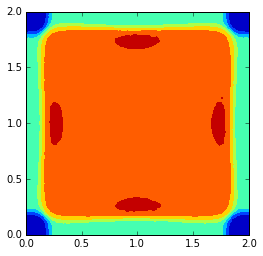

Simulation completed!
Monitored for: 0:06:14.339446.


In [13]:
monitor_simulation(refresh=5.0)

## Comparison with a direct, non-monitored run

In order to perform a measurement of the entire simulation running directly without any IPython interactive monitoring or thread overhead, you can rerun this notebook skipping the two cells above and instead executing the following one.  The output value will be the total simulation time in seconds.

In [ ]:
r = view.apply_async(lambda : ns.calculateSolution('run1'))
r.wait()
r.wall_time

In our experiments so far, running the monitored version with an update interval of 5s produces a negligible overhead of ~ 0.5-1%, while updating every 1s raises it to ~20%.

## Conclusion

This report shows how IPython can be used to provide interactive introspection, monitoring and control capabilities to existing Python HPC codes that use MPI, requiring only trivial and non-intrusive modifications to the codes that don't introduce any permanent IPython dependency.  We have illustrated this by monitoring a shallow water simulation performed with the Proteus toolkit.

The only assumption made was that the HPC code has a "doit" method or function that runs the main body of the code.  If the code has fine-grained time-stepping control, we can use IPython to manually move the time step forward, pause and restart the simulation, and modify intermediate variables.  But even if only a global "do it all" capability exists, we can still introspect and monitor the simulation's evolution, visualizing intermediate results as they are generated in the HPC nodes but using our local visualization capabilities.  This allows for human analysis of the simulation as the process is ongoing, without having to add visualization support to the main code or having to slow down the simulation for interactive introspection.

We know of no other system that provides interactive monitoring and visualization of a traditional MPI code with such low development effort, changes to the existing code and performance impact.